In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from data_gen import data_gen
from model_seq2seq import Seq2SeqModel
from model_generator import Generator
from simple_loss_compute import SimpleLossCompute
from run_epoch import run_epoch
from print_examples import print_examples
from iclib.core import init_seed, pt_init, pt_use_cuda, pt_device
from iclib.print_info import set_print, toggle_print, p_hb, p_he, p_ti

In [3]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

In [4]:
pt_init()
#pt_init(use_gpu=False)
print("CUDA:", pt_use_cuda())
print("DEVICE:", pt_device())

init_seed(42)
set_print(False)

V = 11
E = 32
H = 64
L = 1
dropout = 0.1

S = 10

CUDA: True
DEVICE: cuda:0


In [18]:
model = Seq2SeqModel(V, V, E, E, H, L, dropout, Generator(H, V))

if pt_use_cuda():
    model.cuda(pt_device())
    
criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
optim = torch.optim.Adam(model.parameters(), lr=0.0003)

eval_data = list(data_gen(num_words=V, batch_size=1, num_batches=100))
dev_perplexities = []

In [19]:
for epoch in range(10):
    print("Epoch %d" % epoch)
    model.train()
    data = data_gen(num_words=V, batch_size=32, num_batches=100)
    run_epoch(data, model, SimpleLossCompute(model.generator, criterion, optim))
    
    model.eval()
    with torch.no_grad(): 
        perplexity = run_epoch(eval_data, model, SimpleLossCompute(model.generator, criterion, None))
        print("Evaluation perplexity: %f" % perplexity)
        dev_perplexities.append(perplexity)
        print_examples(eval_data, model, n=2, max_len=9)
        


Epoch 0
Epoch Step: 50 Loss: 19.852442 Tokens per Sec: 14333.259829
Epoch Step: 100 Loss: 17.783201 Tokens per Sec: 14401.510779
total_tokens:28800
total_tokens:900
Evaluation perplexity: 7.381318

Example #1
Src :  8 10 10 4 6 8 10 6 6
Trg :  8 10 10 4 6 8 10 6 6
Pred:  6 6 6 6 6 6 6 6 6

Example #2
Src :  3 6 3 5 2 10 4 8 3
Trg :  3 6 3 5 2 10 4 8 3
Pred:  3 3 3 3 3 3 3 3 3

Epoch 1
Epoch Step: 50 Loss: 15.420979 Tokens per Sec: 13739.797199
Epoch Step: 100 Loss: 12.863676 Tokens per Sec: 13847.674969
total_tokens:28800
total_tokens:900
Evaluation perplexity: 3.969944

Example #1
Src :  8 10 10 4 6 8 10 6 6
Trg :  8 10 10 4 6 8 10 6 6
Pred:  10 10 6 10 6 10 6 10 6

Example #2
Src :  3 6 3 5 2 10 4 8 3
Trg :  3 6 3 5 2 10 4 8 3
Pred:  3 3 6 3 4 3 3 3 10

Epoch 2
Epoch Step: 50 Loss: 9.269669 Tokens per Sec: 13628.566613
Epoch Step: 100 Loss: 8.007423 Tokens per Sec: 13960.938022
total_tokens:28800
total_tokens:900
Evaluation perplexity: 2.388028

Example #1
Src :  8 10 10 4 6 8 10 6 6

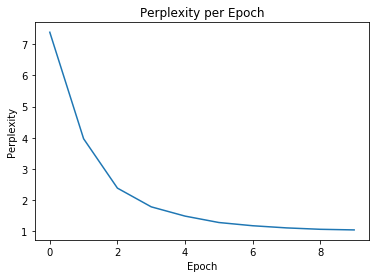

In [20]:
plot_perplexity(dev_perplexities)

In [22]:
mpath = Path('.')/'models'
mfile = mpath/'copy-task.pth'
torch.save(model.state_dict(), mfile)